In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install dataframe_image

In [4]:
from PIL import Image
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
import csv
from imutils import resize
from collections import namedtuple
import os
import tempfile
import random
import tensorflow as tf
import numpy as np
from google.protobuf import text_format
from bs4 import BeautifulSoup
import cv2
import pytesseract as pt
import pandas as pd
import dataframe_image as dfi
from imutils import paths, resize
from imutils.object_detection import non_max_suppression
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
from IPython.display import HTML

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract
from pytesseract import Output

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['resize', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
def display_img(image):
  plt.figure(figsize=(10,10))
  plt.imshow(image,cmap='gray')
  plt.show()

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Fintab/table 11-25 exp2 512x512 96.3/mymodel_best')

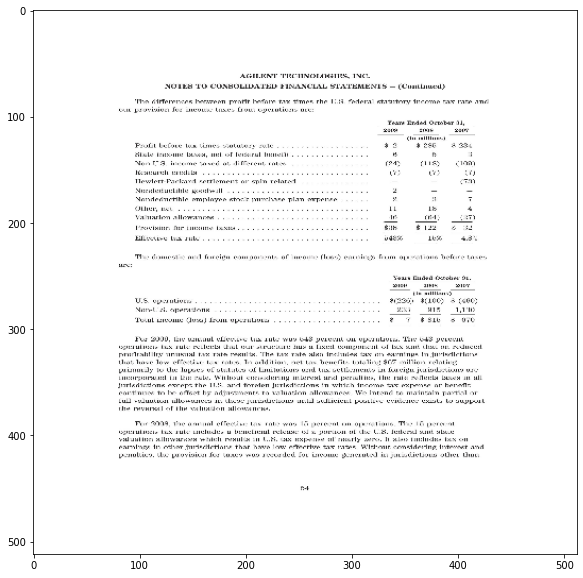

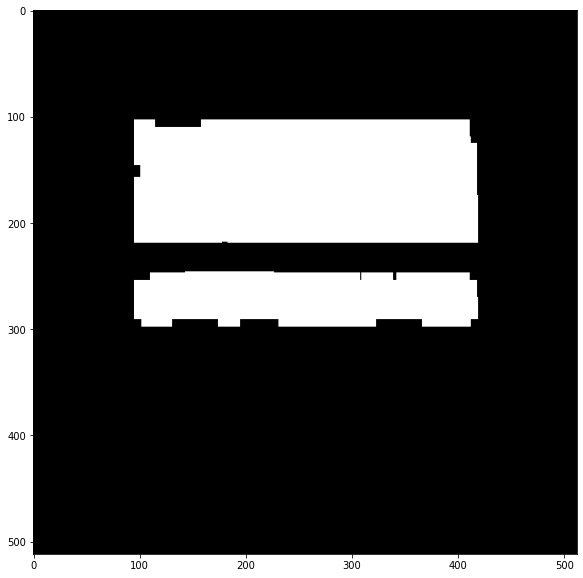

In [ ]:
# load image
filename = '/content/A_2009_page_72.jpg'
image = tf.io.read_file(filename)
image = tf.image.decode_jpeg(image, channels=3) #Decode a JPEG-encoded image to a uint8 tensor
image = tf.image.resize(image , [512,512])
image = tf.cast(image, tf.float32) / 255.0 # normalizing image
display_img(image)

# predict table mask
table_mask = model.predict(image[np.newaxis,:,:,:])
table_mask = tf.argmax(table_mask, axis=-1)
table_mask = table_mask[..., tf.newaxis]
table_mask = table_mask[0]
table_mask = tf.keras.preprocessing.image.array_to_img(table_mask)
table_mask = np.array(table_mask)
ret, table_mask = cv2.threshold(table_mask, 120, 255, cv2.THRESH_BINARY)
kernel = np.ones((5,5), np.uint8)
table_mask = cv2.erode(table_mask, kernel, iterations=3)
table_mask = cv2.dilate(table_mask, kernel, iterations=4)
display_img(table_mask)

# image = cv2.imread('/content/drive/MyDrive/Fintab/mixed_data/extracted_table/BAX_2014_page_87.jpg',0)
# # display_img(image)
# ret, image = cv2.threshold(image, 120, 255, cv2.THRESH_BINARY)
# kernel = np.ones((5,5), np.uint8)
# image = cv2.erode(image, kernel, iterations=3)
# # display_img(img_erosion)
# image = cv2.dilate(image, kernel, iterations=4)
# display_img(image)

In [ ]:
image = cv2.imread(filename)
# display_img(original_image)
table_mask = cv2.resize(table_mask,image.shape[0:2][::-1])
image.shape[0:2],table_mask.shape

((2938, 2313), (2938, 2313))

2
455157.0


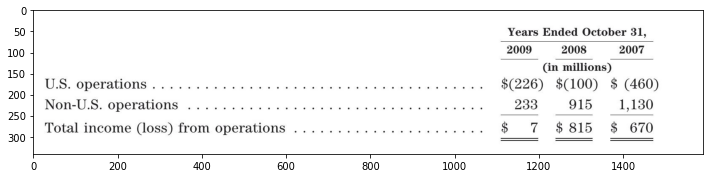

995072.0


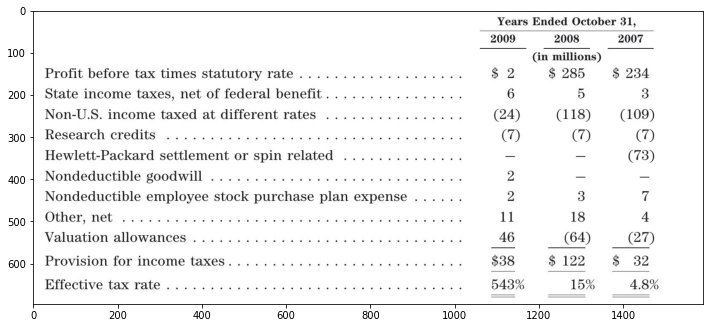

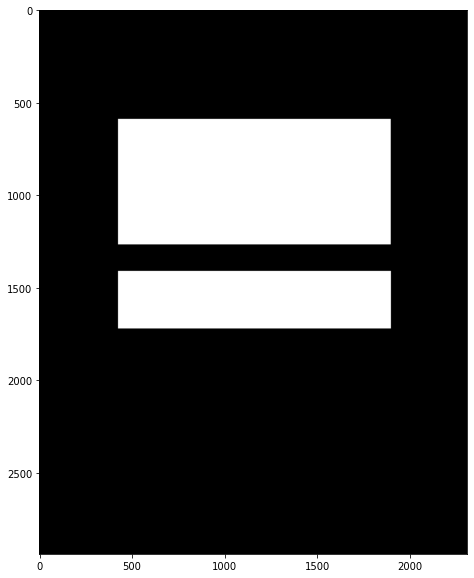

In [ ]:
contours, hierarchy = cv2.findContours(table_mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print(len(contours))
crop_images_list=[]
for i,contour in enumerate(contours):
  x,y,w,h = cv2.boundingRect(contour)
  xmin = round(0.95*x)
  xmax = round(1.05*(x+w))
  ymin = round(0.99*y)
  ymax = round(1.01*(y+h))
  print(cv2.contourArea(contour))
  # print(xmin,xmax,ymin,ymax)
  cv2.rectangle(table_mask,(x,y),(x+w,y+h),(255,255,0),-1)
  crop_img = image[ymin:ymax, xmin:xmax]
  # print(crop_img)
  plt.figure(figsize=(12,12))
  plt.imshow(crop_img)
  plt.show()
  crop_images_list.append(crop_img)
  # cv2.imwrite(f'crop_image{i+1}.jpg',crop_img)

display_img(table_mask)

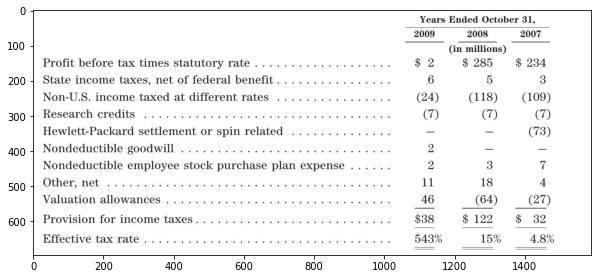

In [ ]:
display_img(crop_images_list[1])
custom_config = r'-l eng --oem 3 --psm 6 -c tessedit_char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789-:.$%./@& *"'
d = pytesseract.image_to_data(crop_images_list[1], config=custom_config, output_type=Output.DICT)
df = pd.DataFrame(d)

In [ ]:
pd.set_option('display.max_rows', None)
df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,1589,696,-1,
1,2,1,1,0,0,0,28,17,1455,645,-1,
2,3,1,1,1,0,0,28,17,1455,645,-1,
3,4,1,1,1,1,0,1102,17,327,24,-1,
4,5,1,1,1,1,1,1102,17,71,19,96,Years
5,5,1,1,1,1,2,1184,17,84,19,96,Ended
6,5,1,1,1,1,3,1279,17,104,19,96,October
7,5,1,1,1,1,4,1394,17,35,24,96,"31,"
8,4,1,1,1,2,0,1086,58,361,19,-1,
9,5,1,1,1,2,1,1086,58,58,19,96,2009


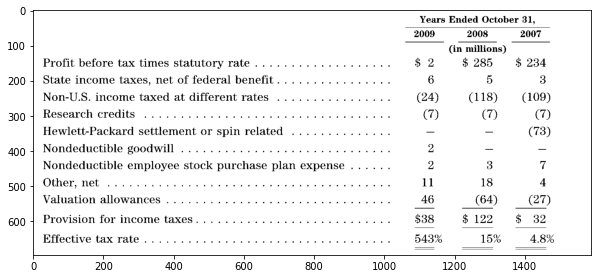

In [ ]:
gray_image = cv2.cvtColor(crop_images_list[1], cv2.COLOR_BGR2GRAY)
threshold_img = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
display_img(threshold_img)

In [ ]:
test_image = crop_images_list[1].copy()
test_image.shape

(696, 1589, 3)

In [ ]:
# img = test_image.copy()
# hImg, wImg, _ = img.shape

# # boxes = pytesseract.image_to_boxes(img)
# for row in df.iterrows():
#   # b = b.split(' ')
#   # print(b)
#   x, y, w, h = int(row[1]['left']), int(row[1]['top']), int(row[1]['width']), int(row[1]['height'])
#   img = cv2.rectangle(img, (x,y), (x+w,y+h), (50, 50, 255), 1)
#   # img = cv2.putText(img, b[0], (x, hImg - y + 13), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (50, 205, 50), 1)
# display_img(img)

In [ ]:
# looping over row pixels
hor_lines = []
for ir in range(0,test_image.shape[0]):
  flag = True
  for row in df.iterrows():
    ymin = row[1]['top']
    ymax = ymin + row[1]['height']
    
    if int(row[1]['conf'])<50:
      continue
    if ymin<=ir<=ymax:
      # print(f'1line at {ir}')
      # print(row[1])
      flag = False
      break

  if flag==True:
    hor_lines.append(ir)

print(lines_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 94, 95, 96, 97, 98, 120, 121, 122, 123, 124, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 187, 188, 189, 190, 191, 192, 219, 220, 221, 222, 223, 224, 225, 253, 254, 255, 256, 257, 258, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 324]


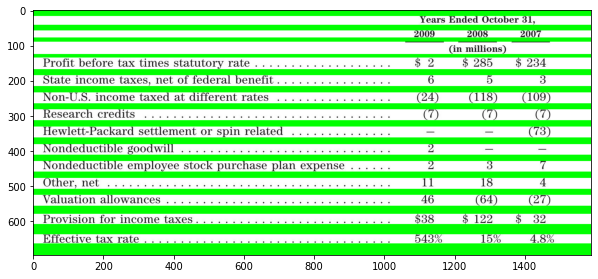

In [ ]:
color = (0,255,0)
thickness = 1

for i in hor_lines:
  start_point = (0,i)
  end_point = (test_image.shape[1]+10,i)
  test_image = cv2.line(test_image,start_point,end_point,color,thickness)

display_img(test_image)

In [ ]:
vert_lines = []
total_lines = max(df['line_num'])
for ij in range(test_image.shape[1]):
  flag  = True
  rows_blocking = []
  for row in df.iterrows():
    char_len = len(row[1]['text'].replace(',','').replace('.',''))
    if char_len==0:
      continue
    avg_char_width = row[1]['width']/char_len
    xmin = row[1]['left'] - 0.55*avg_char_width
    xmax = row[1]['left'] + row[1]['width'] + 0.55*avg_char_width

    if int(row[1]['conf'])<40:
      continue
    if xmin<=ij<=xmax:
      # print(f'1line at {ij}')
      # print(row[1]['left'],row[1]['text'])
      flag = False
      rows_blocking.append(row[1]['line_num'])
      # break

  if len(rows_blocking)>=0.1*total_lines:
    continue
  else:
    flag=True

  if flag==True:
    vert_lines.append(ij)

print(vert_lines)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 896, 897, 898, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 15

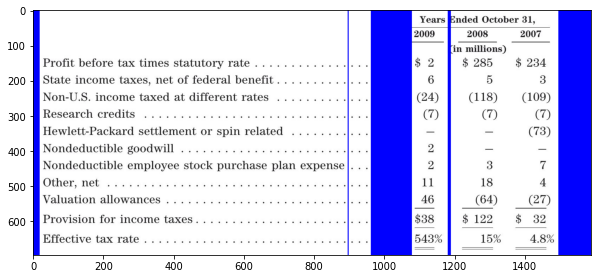

In [ ]:
color = (0,0,255)
thickness = 1

for i in vert_lines:
  start_point = (i,0)
  end_point = (i,test_image.shape[0]+10)
  test_image = cv2.line(test_image,start_point,end_point,color,thickness)

display_img(test_image)

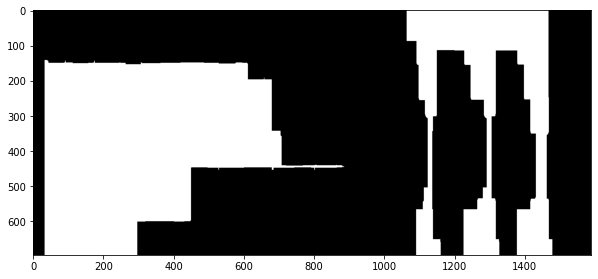

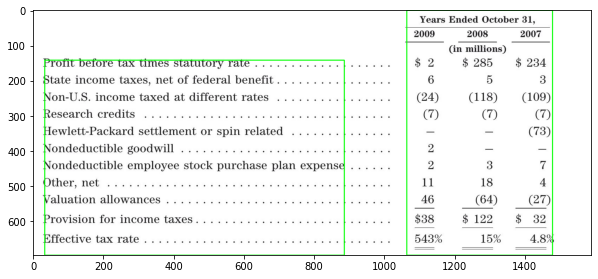

In [ ]:
gray = cv2.cvtColor(crop_images_list[1], cv2.COLOR_BGR2GRAY)
 
# Performing OTSU threshold
ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
 
# Specify structure shape and kernel size.
# Kernel size increases or decreases the area
# of the rectangle to be detected.
# A smaller value like (10, 10) will detect
# each word instead of a sentence.
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 15))
kernel = np.ones((5,5))
 
# Applying dilation on the threshold image
dilation = cv2.dilate(thresh1, rect_kernel, iterations = 10)
dilation = cv2.erode(dilation, kernel, iterations = 2)
dilation = cv2.dilate(dilation , kernel , iterations = 10)
dilation = cv2.erode(dilation , kernel , iterations = 10)
dilation = cv2.erode(dilation , rect_kernel , iterations = 10)


display_img(dilation)
 
# Finding contours
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,
                                                 cv2.CHAIN_APPROX_NONE)
 
# Creating a copy of image
im2 = crop_images_list[1].copy()
 
# Looping through the identified contours
# Then rectangular part is cropped and passed on
# to pytesseract for extracting text from it
# Extracted text is then written into the text file
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
     
    # Drawing a rectangle on copied image
    rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2)
     
    # # Cropping the text block for giving input to OCR
    # cropped = im2[y:y + h, x:x + w]
     
    # # Open the file in append mode
    # file = open("recognized.txt", "a")
     
    # # Apply OCR on the cropped image
    # text = pytesseract.image_to_string(cropped)
     
    # # Appending the text into file
    # file.write(text)
    # file.write("\n")
     
    # # Close the file
    # file.close

display_img(im2)